In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa, os, cv2, pickle, tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [ ]:
emo = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/EMODB_OpenSMILE_Features.csv')
sav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/SAVEE_OpenSMILE_Features.csv')
rav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/RAVDESS_OpenSMILE_Features.csv')
iem = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/IEMOCAP_OpenSMILE_Features_2.csv')

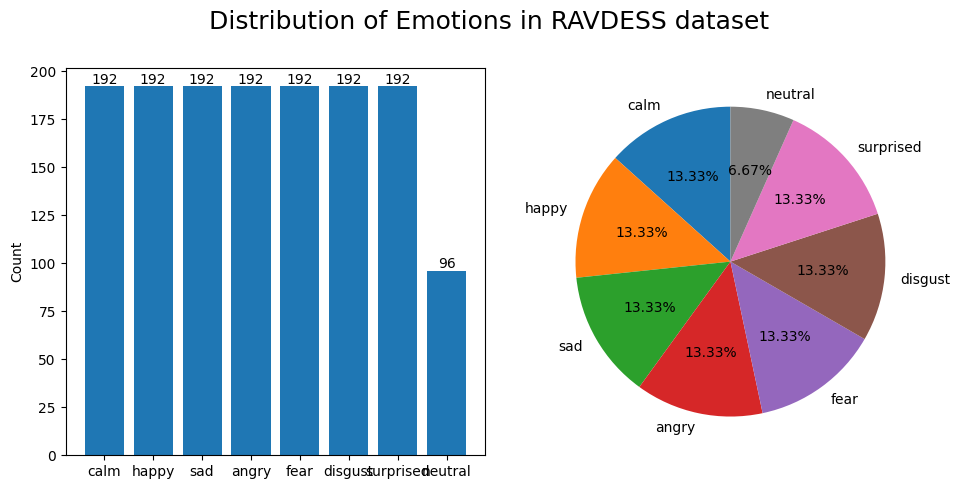

In [ ]:
rav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/RAVDESS_OpenSMILE_Features.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(rav['label'].value_counts().index, rav['label'].value_counts().values)
plt.ylabel("Count")
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),bar.get_height(), ha='center', va='bottom')
plt.subplot(1, 2, 2)
rav['label'].value_counts().plot(kind='pie',autopct='%1.2f%%',startangle=90)
plt.ylabel('')
plt.suptitle('Distribution of Emotions in RAVDESS dataset', fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

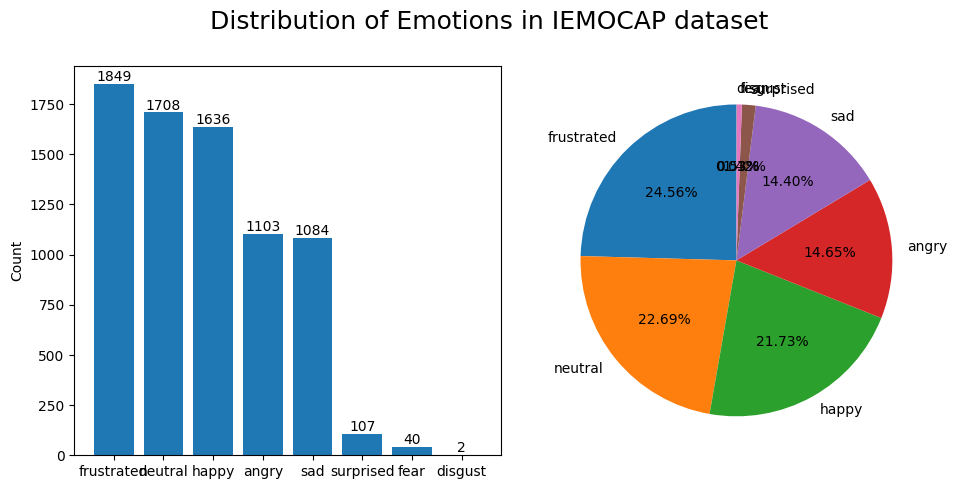

In [ ]:
iem = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/IEMOCAP_OpenSMILE_Features_2.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(iem['label'].value_counts().index, iem['label'].value_counts().values)
plt.ylabel("Count")
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),bar.get_height(), ha='center', va='bottom')
plt.subplot(1, 2, 2)
iem['label'].value_counts().plot(kind='pie',autopct='%1.2f%%',startangle=90)
plt.ylabel('')
plt.suptitle('Distribution of Emotions in IEMOCAP dataset', fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

In [ ]:
emo

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,2.953248,0.187879,0.000000,0.384680,0.594503,1.110925,0.209824,0.516421,0.726245,0.042545,...,0.377489,3.073306,3.023500,18.488369,0.703086,127.580150,63.120970,111.503200,50.327580,happy
1,3.155534,0.133858,0.007874,0.473100,0.882362,1.285896,0.409262,0.403534,0.812795,0.047482,...,0.419386,3.648550,3.633723,19.937117,0.461996,164.603880,78.391160,136.406680,72.744270,neutral
2,3.689192,0.678788,0.200000,0.520429,0.966766,1.860860,0.446337,0.894094,1.340431,0.040379,...,0.459132,4.321670,4.341703,-19.905592,0.428707,191.251720,101.405075,189.614120,94.504480,angry
3,3.194681,0.556180,0.747191,0.356068,0.795204,1.467783,0.439135,0.672579,1.111715,0.041676,...,0.459048,3.377349,3.440364,-18.129284,0.449167,162.500490,58.608616,150.581220,106.360230,happy
4,2.619743,0.649573,0.717949,0.601676,0.981279,1.584580,0.379603,0.603301,0.982904,0.051517,...,0.510148,2.772016,2.619547,13.850685,0.490300,100.685520,45.445034,114.359120,50.859130,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,4.081661,0.744828,0.262069,0.588366,0.872083,1.398601,0.283717,0.526518,0.810234,0.098473,...,0.515452,3.154101,3.227233,-17.479996,0.538332,134.987530,60.826520,107.085750,49.623726,disgust
531,2.783625,0.091772,0.000000,0.418646,0.975762,1.457792,0.557116,0.482030,1.039146,0.110163,...,0.516277,2.880578,2.910725,-19.303038,0.538864,129.712510,86.344020,103.774254,67.182130,sad
532,1.856336,0.108108,0.310811,0.231162,0.631234,1.061064,0.400072,0.429829,0.829902,0.104655,...,0.456415,2.434459,2.469719,-18.739914,0.552656,104.500854,48.482590,96.459045,48.845070,sad
533,3.326925,0.402062,0.144330,0.374059,0.666930,0.952829,0.292871,0.285899,0.578770,0.081112,...,0.476342,4.142833,4.046732,17.478539,0.474182,160.723970,69.441520,164.850850,77.994415,angry


In [ ]:
print("EMODB SHAPE =",emo.shape)
print("SAVEE SHAPE =",sav.shape)
print("RAVDESS SHAPE =",rav.shape)
print("IEMOCAP SHAPE =",iem.shape)

EMODB SHAPE = (535, 6374)
SAVEE SHAPE = (480, 6374)
RAVDESS SHAPE = (1440, 6374)
IEMOCAP SHAPE = (7529, 6375)


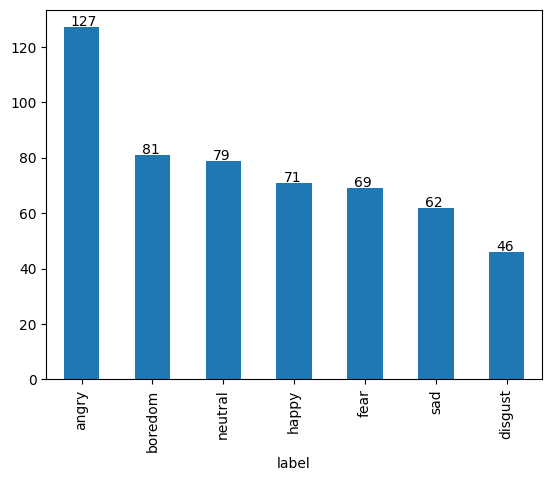

In [ ]:
ax = emo['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.005))
plt.title("Emotion Distribution in EMO-DB Dataset")
plt.show()

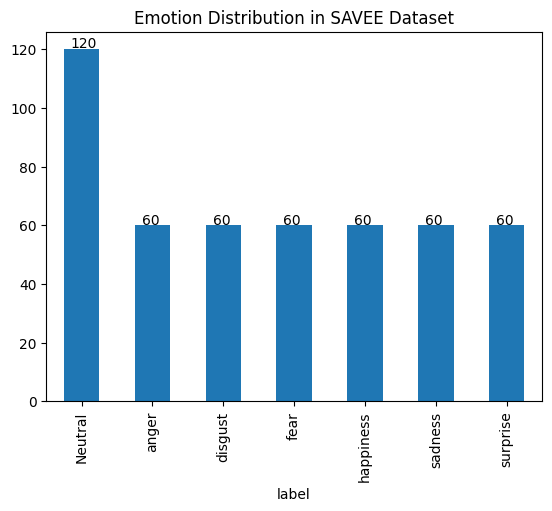

In [ ]:
ax = sav['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.005))
plt.title("Emotion Distribution in SAVEE Dataset")
plt.show()

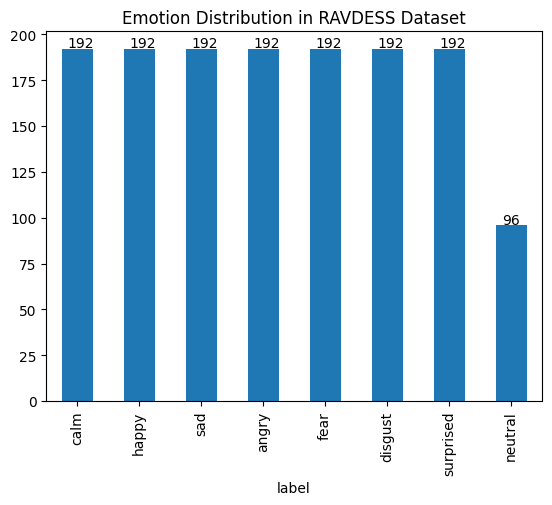

In [ ]:
ax = rav['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.005))
plt.title("Emotion Distribution in RAVDESS Dataset")
plt.show()

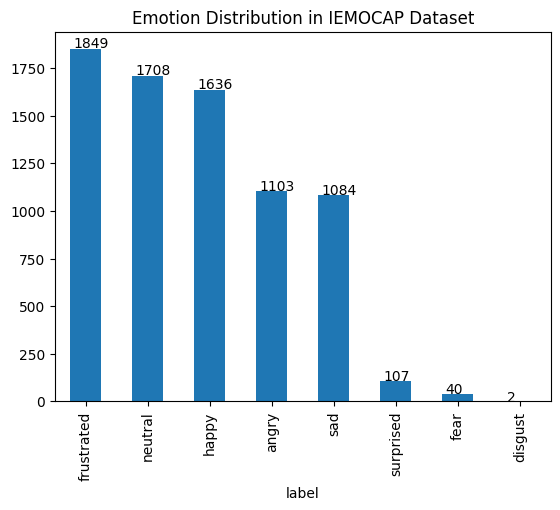

In [ ]:
ax = iem['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005))
plt.title("Emotion Distribution in IEMOCAP Dataset")
plt.show()

In [ ]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  model.fit(trainX, trainY)
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  return acc

In [ ]:
def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

# Training and Testing on EMO-DB Dataset

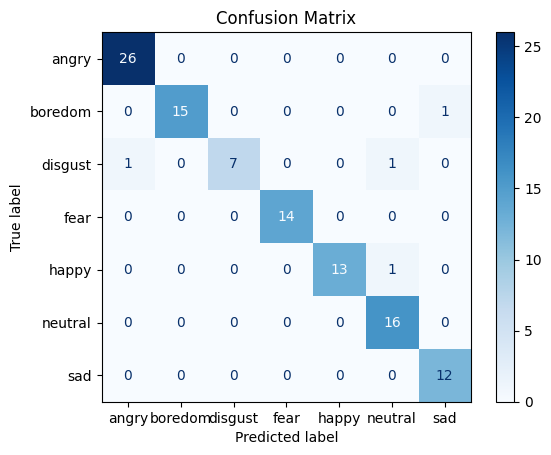


Logistic Regression Accuracy: 96.262%
              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        26
     boredom       1.00      0.94      0.97        16
     disgust       1.00      0.78      0.88         9
        fear       1.00      1.00      1.00        14
       happy       1.00      0.93      0.96        14
     neutral       0.89      1.00      0.94        16
         sad       0.92      1.00      0.96        12

    accuracy                           0.96       107
   macro avg       0.97      0.95      0.96       107
weighted avg       0.97      0.96      0.96       107



In [ ]:
lr_model = LogisticRegression(C=0.3,class_weight='balanced')
acc_lr = preprocess_split_train_test(emo,lr_model,'Logistic Regression',rs=710,apply_LDA=False)

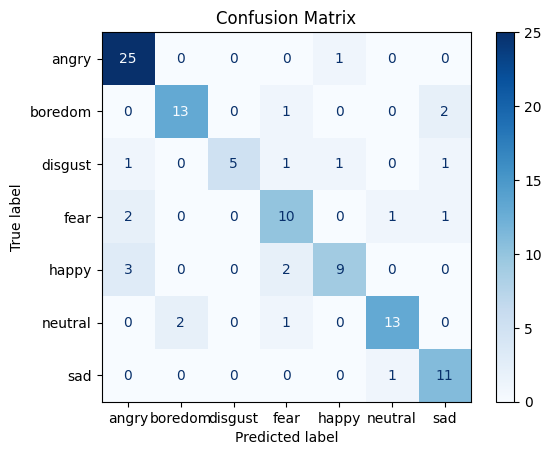


Decision Tree Accuracy: 80.374%
              precision    recall  f1-score   support

       angry       0.81      0.96      0.88        26
     boredom       0.87      0.81      0.84        16
     disgust       1.00      0.56      0.71         9
        fear       0.67      0.71      0.69        14
       happy       0.82      0.64      0.72        14
     neutral       0.87      0.81      0.84        16
         sad       0.73      0.92      0.81        12

    accuracy                           0.80       107
   macro avg       0.82      0.77      0.78       107
weighted avg       0.82      0.80      0.80       107



In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,min_samples_leaf=8,random_state=30)
acc_dt = preprocess_split_train_test(emo,dt_model,'Decision Tree')

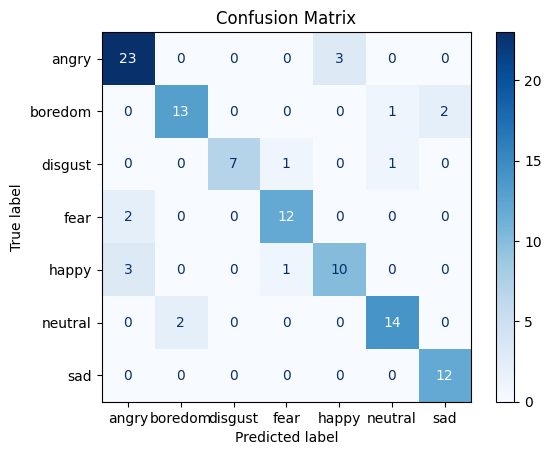


Random Forest Accuracy: 85.047%
              precision    recall  f1-score   support

       angry       0.82      0.88      0.85        26
     boredom       0.87      0.81      0.84        16
     disgust       1.00      0.78      0.88         9
        fear       0.86      0.86      0.86        14
       happy       0.77      0.71      0.74        14
     neutral       0.88      0.88      0.88        16
         sad       0.86      1.00      0.92        12

    accuracy                           0.85       107
   macro avg       0.86      0.85      0.85       107
weighted avg       0.85      0.85      0.85       107



In [ ]:
rf_model = RandomForestClassifier(n_estimators=700,random_state=24)
acc_rf = preprocess_split_train_test(emo,rf_model,'Random Forest')

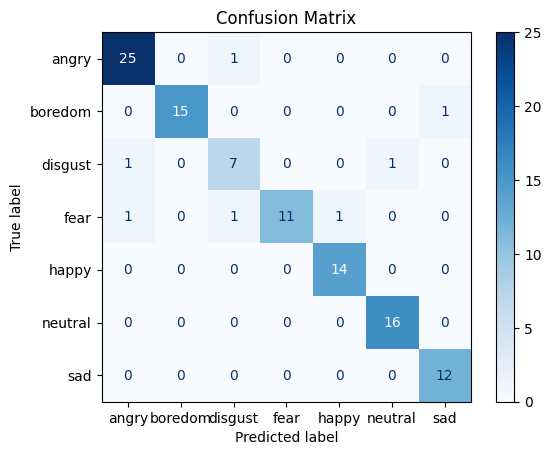


SVM Accuracy: 93.458%
              precision    recall  f1-score   support

       angry       0.93      0.96      0.94        26
     boredom       1.00      0.94      0.97        16
     disgust       0.78      0.78      0.78         9
        fear       1.00      0.79      0.88        14
       happy       0.93      1.00      0.97        14
     neutral       0.94      1.00      0.97        16
         sad       0.92      1.00      0.96        12

    accuracy                           0.93       107
   macro avg       0.93      0.92      0.92       107
weighted avg       0.94      0.93      0.93       107



In [ ]:
svm_model = SVC(class_weight='balanced',C=0.75,random_state=42,kernel='linear')
acc_svm = preprocess_split_train_test(emo,svm_model,'SVM',rs=710,apply_LDA=False)

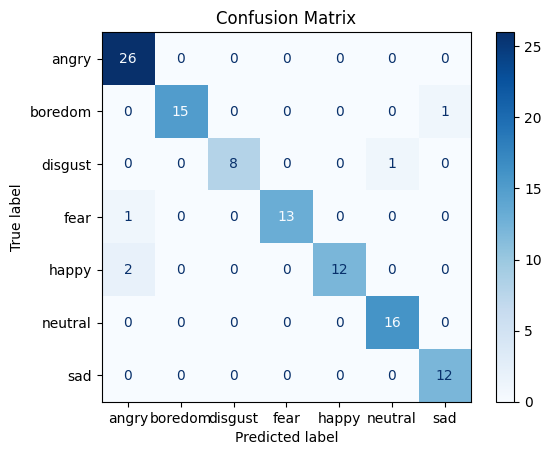


KNN Accuracy: 95.327%
              precision    recall  f1-score   support

       angry       0.90      1.00      0.95        26
     boredom       1.00      0.94      0.97        16
     disgust       1.00      0.89      0.94         9
        fear       1.00      0.93      0.96        14
       happy       1.00      0.86      0.92        14
     neutral       0.94      1.00      0.97        16
         sad       0.92      1.00      0.96        12

    accuracy                           0.95       107
   macro avg       0.97      0.94      0.95       107
weighted avg       0.96      0.95      0.95       107



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
acc_knn = preprocess_split_train_test(emo,knn_model,'KNN',rs=710)

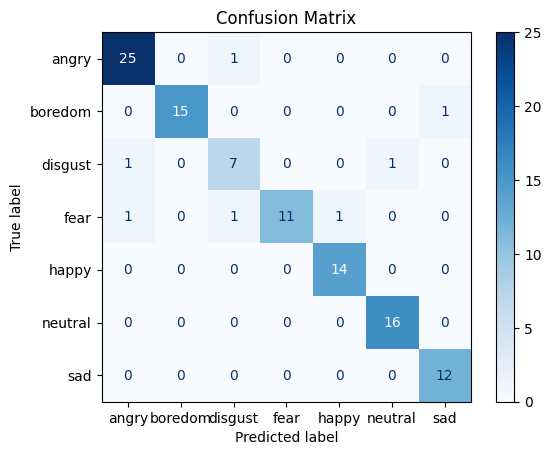


AdaBoost Accuracy: 93.458%
              precision    recall  f1-score   support

       angry       0.93      0.96      0.94        26
     boredom       1.00      0.94      0.97        16
     disgust       0.78      0.78      0.78         9
        fear       1.00      0.79      0.88        14
       happy       0.93      1.00      0.97        14
     neutral       0.94      1.00      0.97        16
         sad       0.92      1.00      0.96        12

    accuracy                           0.93       107
   macro avg       0.93      0.92      0.92       107
weighted avg       0.94      0.93      0.93       107



In [ ]:
ab_model = AdaBoostClassifier(estimator=svm_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(emo,ab_model,'AdaBoost',rs=710,apply_LDA=False)

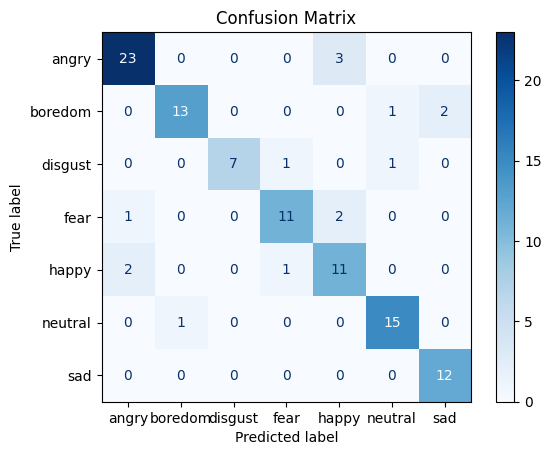


Naive Bayes Accuracy: 85.981%
              precision    recall  f1-score   support

       angry       0.88      0.88      0.88        26
     boredom       0.93      0.81      0.87        16
     disgust       1.00      0.78      0.88         9
        fear       0.85      0.79      0.81        14
       happy       0.69      0.79      0.73        14
     neutral       0.88      0.94      0.91        16
         sad       0.86      1.00      0.92        12

    accuracy                           0.86       107
   macro avg       0.87      0.85      0.86       107
weighted avg       0.87      0.86      0.86       107



In [ ]:
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(emo,nb_model,'Naive Bayes')

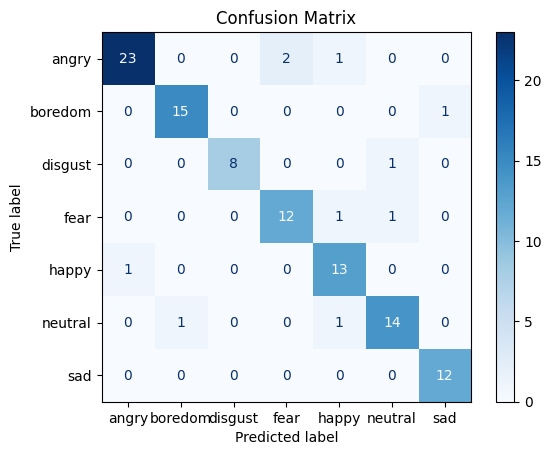


XGBoost Accuracy: 90.654%
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.94      0.94      0.94        16
           2       1.00      0.89      0.94         9
           3       0.86      0.86      0.86        14
           4       0.81      0.93      0.87        14
           5       0.88      0.88      0.88        16
           6       0.92      1.00      0.96        12

    accuracy                           0.91       107
   macro avg       0.91      0.91      0.91       107
weighted avg       0.91      0.91      0.91       107



In [ ]:
xgb_model = XGBClassifier()
acc_xgb = preprocess_split_train_test(emo,xgb_model,'XGBoost',rs=710)

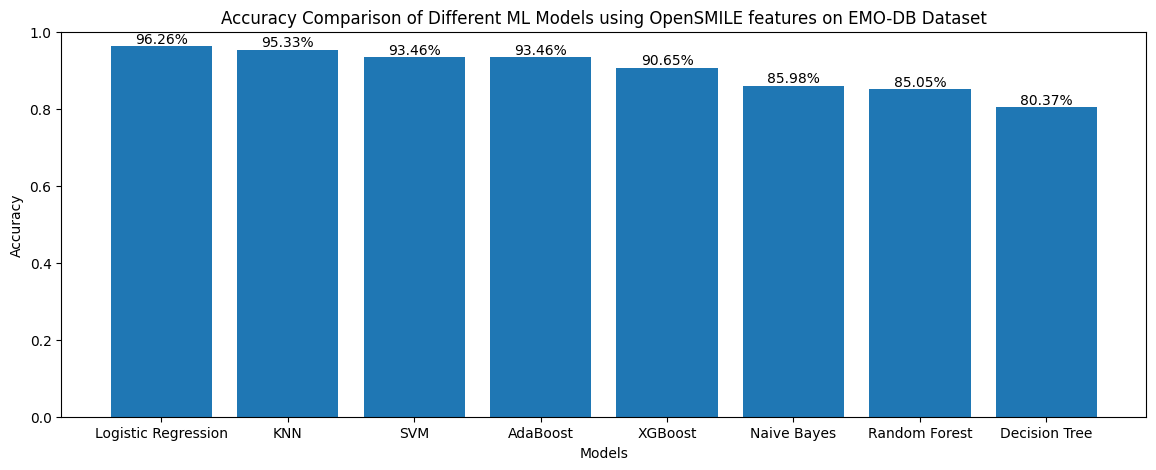

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN','AdaBoost','Naive Bayes','XGBoost']
accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn,acc_ab,acc_nb,acc_xgb]
modacc = dict(zip(models, accuracies))
modacc = sorted(modacc.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*modacc)
plt.figure(figsize=(14, 5))
bars = plt.bar(models, accuracies)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
plt.title(f'Accuracy Comparison of Different ML Models using OpenSMILE features on EMO-DB Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Training and Testing on RAVDESS Dataset

In [ ]:
maxacc = 0.822 #200
for rs in tqdm.tqdm(range(400,600)):
  lr_model = LogisticRegression(C=0.3)
  acc_lr = preprocess_split_train_test(rav,lr_model,'Logistic Regression',rs=rs,printres=False)
  if acc_lr > maxacc:
    print("Random State =",rs)
    print(f"Accuracy: {acc_lr*100:.3f}%\n")
    maxacc = acc_lr
    maxrs = rs
print("Best Random State =",maxrs)

100%|██████████| 200/200 [13:45<00:00,  4.13s/it]

Best Random State = 200


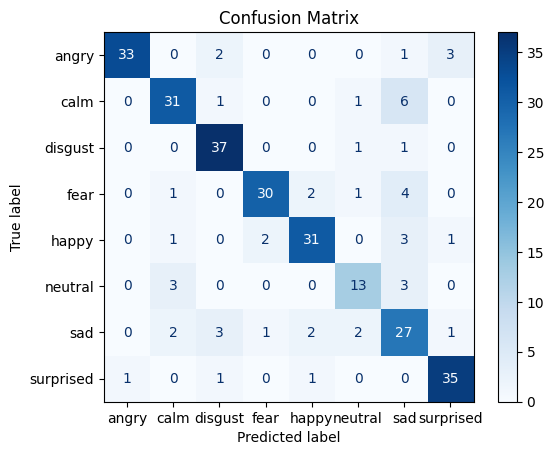


Logistic Regression Accuracy: 82.292%
              precision    recall  f1-score   support

       angry       0.97      0.85      0.90        39
        calm       0.82      0.79      0.81        39
     disgust       0.84      0.95      0.89        39
        fear       0.91      0.79      0.85        38
       happy       0.86      0.82      0.84        38
     neutral       0.72      0.68      0.70        19
         sad       0.60      0.71      0.65        38
   surprised       0.88      0.92      0.90        38

    accuracy                           0.82       288
   macro avg       0.82      0.81      0.82       288
weighted avg       0.83      0.82      0.82       288



In [ ]:
lr_model = LogisticRegression(C=0.3)
lr_model2,scaler,acc_lr = preprocess_split_train_test(rav,lr_model,'Logistic Regression',rs=200,apply_LDA=False,returnModelFiles=True)

In [ ]:
idx = 96
rav.iloc[idx:idx+1,:].values

array([[1.5960904, 0.566879, 0.7006369, ..., 130.26895, 83.07615, 'fear']],
      dtype=object)

In [ ]:
scl = scaler.transform(rav.iloc[idx:idx+1,:-1])
lr_model2.predict(scl)

array(['fear'], dtype=object)

In [ ]:
fn = 'lr_model2.pkl'
pickle.dump(lr_model2, open(fn, 'wb'))

In [ ]:
fn = 'scaler_for_ravdess.pkl'
pickle.dump(scaler, open(fn, 'wb'))

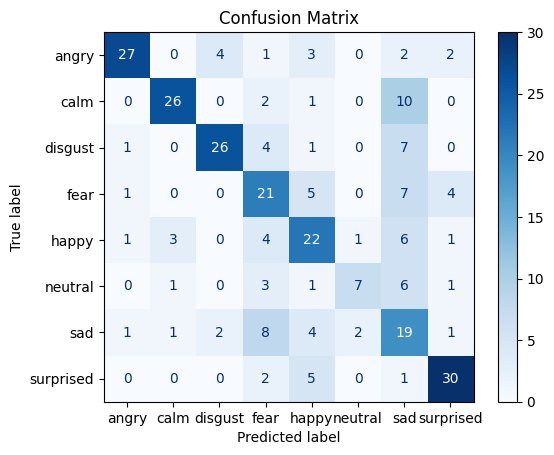


Decision Tree Accuracy: 61.806%
              precision    recall  f1-score   support

       angry       0.87      0.69      0.77        39
        calm       0.84      0.67      0.74        39
     disgust       0.81      0.67      0.73        39
        fear       0.47      0.55      0.51        38
       happy       0.52      0.58      0.55        38
     neutral       0.70      0.37      0.48        19
         sad       0.33      0.50      0.40        38
   surprised       0.77      0.79      0.78        38

    accuracy                           0.62       288
   macro avg       0.66      0.60      0.62       288
weighted avg       0.66      0.62      0.63       288



In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,min_samples_leaf=10,random_state=20)
acc_dt = preprocess_split_train_test(rav,dt_model,'Decision Tree',rs=200)

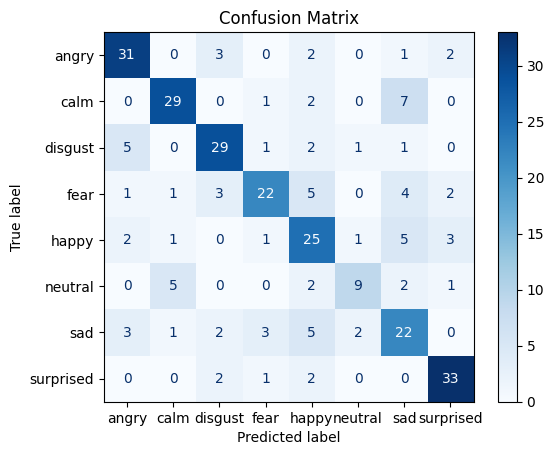


Random Forest Accuracy: 69.444%
              precision    recall  f1-score   support

       angry       0.74      0.79      0.77        39
        calm       0.78      0.74      0.76        39
     disgust       0.74      0.74      0.74        39
        fear       0.76      0.58      0.66        38
       happy       0.56      0.66      0.60        38
     neutral       0.69      0.47      0.56        19
         sad       0.52      0.58      0.55        38
   surprised       0.80      0.87      0.84        38

    accuracy                           0.69       288
   macro avg       0.70      0.68      0.68       288
weighted avg       0.70      0.69      0.69       288



In [ ]:
rf_model = RandomForestClassifier(n_estimators=700,random_state=24)
acc_rf = preprocess_split_train_test(rav,rf_model,'Random Forest',rs=200)

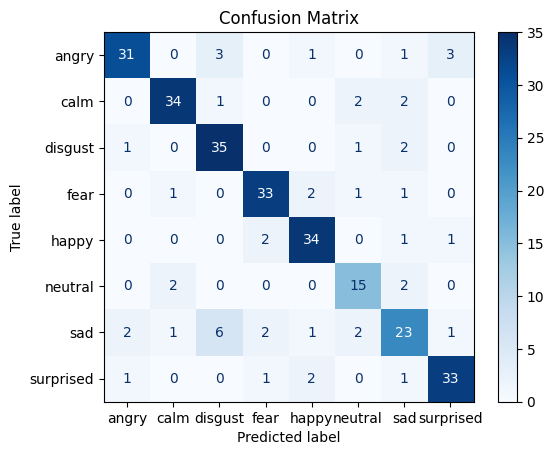


SVM Accuracy: 82.639%
              precision    recall  f1-score   support

       angry       0.89      0.79      0.84        39
        calm       0.89      0.87      0.88        39
     disgust       0.78      0.90      0.83        39
        fear       0.87      0.87      0.87        38
       happy       0.85      0.89      0.87        38
     neutral       0.71      0.79      0.75        19
         sad       0.70      0.61      0.65        38
   surprised       0.87      0.87      0.87        38

    accuracy                           0.83       288
   macro avg       0.82      0.82      0.82       288
weighted avg       0.83      0.83      0.83       288



In [ ]:
svm_model = SVC(C=0.75,random_state=42,kernel='linear')
acc_svm = preprocess_split_train_test(rav,svm_model,'SVM',rs=200,apply_LDA=False)

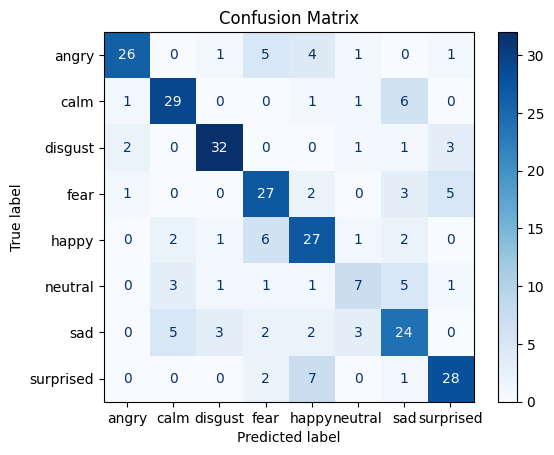


KNN Accuracy: 69.444%
              precision    recall  f1-score   support

       angry       0.87      0.68      0.76        38
        calm       0.74      0.76      0.75        38
     disgust       0.84      0.82      0.83        39
        fear       0.63      0.71      0.67        38
       happy       0.61      0.69      0.65        39
     neutral       0.50      0.37      0.42        19
         sad       0.57      0.62      0.59        39
   surprised       0.74      0.74      0.74        38

    accuracy                           0.69       288
   macro avg       0.69      0.67      0.68       288
weighted avg       0.70      0.69      0.69       288



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=11)
acc_knn = preprocess_split_train_test(rav,knn_model,'KNN')

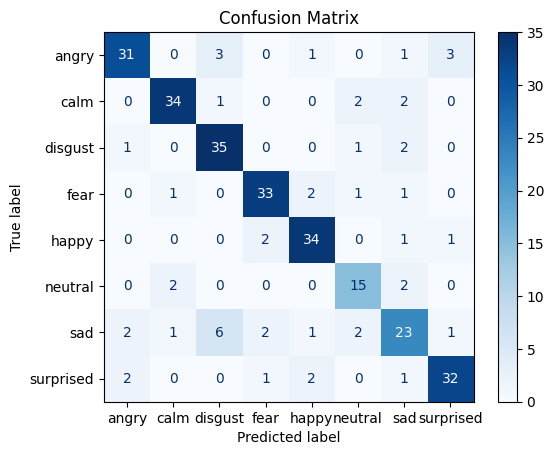


AdaBoost Accuracy: 82.292%
              precision    recall  f1-score   support

       angry       0.86      0.79      0.83        39
        calm       0.89      0.87      0.88        39
     disgust       0.78      0.90      0.83        39
        fear       0.87      0.87      0.87        38
       happy       0.85      0.89      0.87        38
     neutral       0.71      0.79      0.75        19
         sad       0.70      0.61      0.65        38
   surprised       0.86      0.84      0.85        38

    accuracy                           0.82       288
   macro avg       0.82      0.82      0.82       288
weighted avg       0.82      0.82      0.82       288



In [ ]:
ab_model = AdaBoostClassifier(estimator=svm_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(rav,ab_model,'AdaBoost',rs=200,apply_LDA=False)

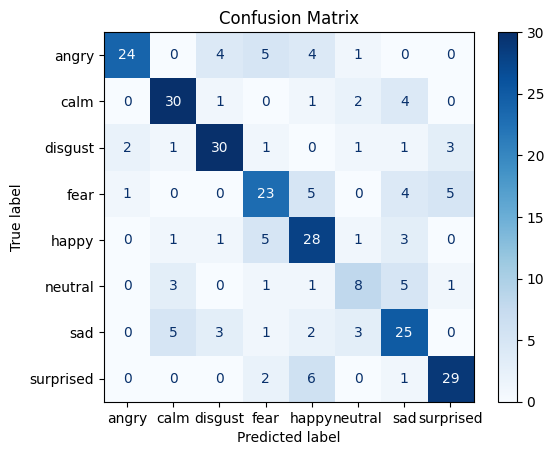


Naive Bayes Accuracy: 68.403%
              precision    recall  f1-score   support

       angry       0.89      0.63      0.74        38
        calm       0.75      0.79      0.77        38
     disgust       0.77      0.77      0.77        39
        fear       0.61      0.61      0.61        38
       happy       0.60      0.72      0.65        39
     neutral       0.50      0.42      0.46        19
         sad       0.58      0.64      0.61        39
   surprised       0.76      0.76      0.76        38

    accuracy                           0.68       288
   macro avg       0.68      0.67      0.67       288
weighted avg       0.69      0.68      0.68       288



In [ ]:
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(rav,nb_model,'Naive Bayes',apply_smote=True)

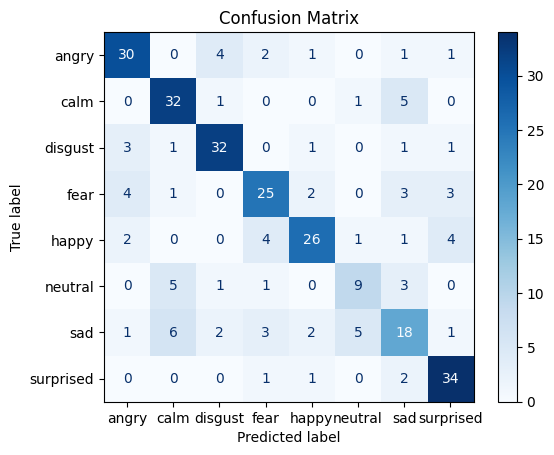


XGBoost Accuracy: 71.528%
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        39
           1       0.71      0.82      0.76        39
           2       0.80      0.82      0.81        39
           3       0.69      0.66      0.68        38
           4       0.79      0.68      0.73        38
           5       0.56      0.47      0.51        19
           6       0.53      0.47      0.50        38
           7       0.77      0.89      0.83        38

    accuracy                           0.72       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.71      0.72      0.71       288



In [ ]:
xgb_model = XGBClassifier()
acc_xgb = preprocess_split_train_test(rav,xgb_model,'XGBoost',rs=200,apply_LDA=False)

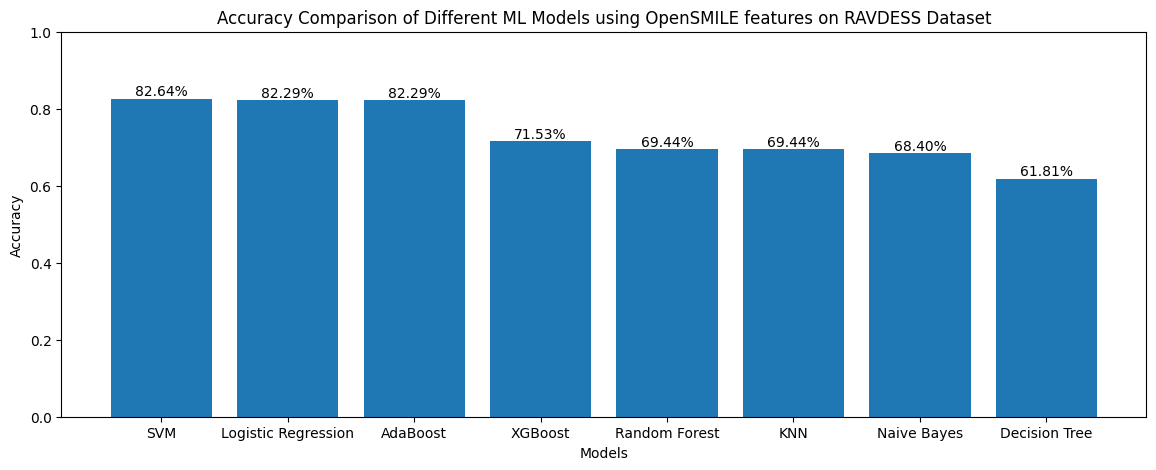

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN','AdaBoost','Naive Bayes','XGBoost']
accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn,acc_ab,acc_nb,acc_xgb]
modacc = dict(zip(models, accuracies))
modacc = sorted(modacc.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*modacc)
plt.figure(figsize=(14, 5))
bars = plt.bar(models, accuracies)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
plt.title(f'Accuracy Comparison of Different ML Models using OpenSMILE features on RAVDESS Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Training and Testing on SAVEE Dataset

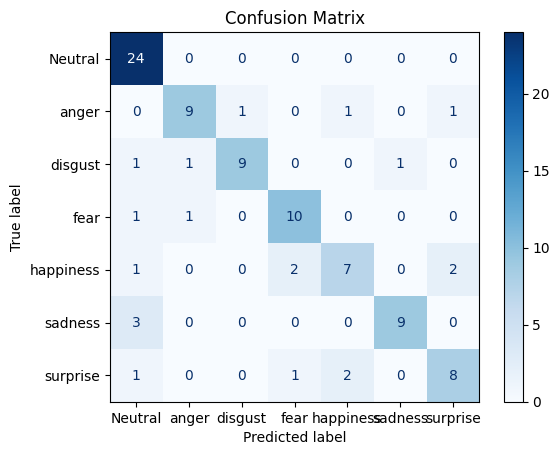


Logistic Regression Accuracy: 79.167%
              precision    recall  f1-score   support

     Neutral       0.77      1.00      0.87        24
       anger       0.82      0.75      0.78        12
     disgust       0.90      0.75      0.82        12
        fear       0.77      0.83      0.80        12
   happiness       0.70      0.58      0.64        12
     sadness       0.90      0.75      0.82        12
    surprise       0.73      0.67      0.70        12

    accuracy                           0.79        96
   macro avg       0.80      0.76      0.77        96
weighted avg       0.80      0.79      0.79        96



In [ ]:
lr_model = LogisticRegression(C=0.3)
acc_lr = preprocess_split_train_test(sav,lr_model,'Logistic Regression',rs=6,apply_LDA=False)

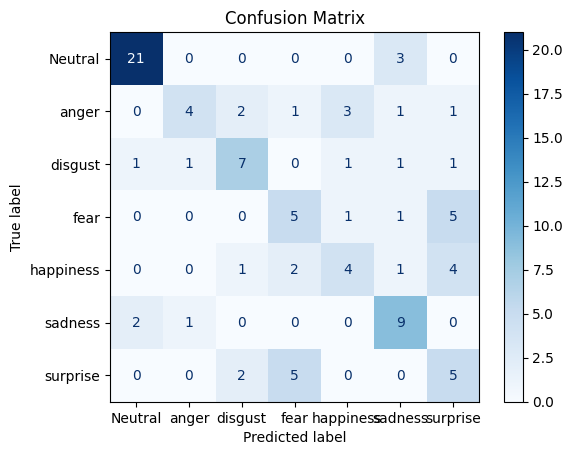


Decision Tree Accuracy: 57.292%
              precision    recall  f1-score   support

     Neutral       0.88      0.88      0.88        24
       anger       0.67      0.33      0.44        12
     disgust       0.58      0.58      0.58        12
        fear       0.38      0.42      0.40        12
   happiness       0.44      0.33      0.38        12
     sadness       0.56      0.75      0.64        12
    surprise       0.31      0.42      0.36        12

    accuracy                           0.57        96
   macro avg       0.55      0.53      0.53        96
weighted avg       0.59      0.57      0.57        96



In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,min_samples_leaf=10,random_state=30)
acc_dt = preprocess_split_train_test(sav,dt_model,'Decision Tree',apply_smote=True)

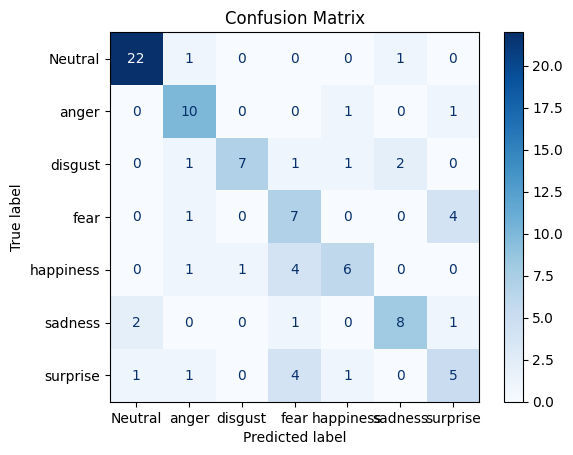


Random Forest Accuracy: 67.708%
              precision    recall  f1-score   support

     Neutral       0.88      0.92      0.90        24
       anger       0.67      0.83      0.74        12
     disgust       0.88      0.58      0.70        12
        fear       0.41      0.58      0.48        12
   happiness       0.67      0.50      0.57        12
     sadness       0.73      0.67      0.70        12
    surprise       0.45      0.42      0.43        12

    accuracy                           0.68        96
   macro avg       0.67      0.64      0.65        96
weighted avg       0.70      0.68      0.68        96



In [ ]:
rf_model = RandomForestClassifier(n_estimators=150,random_state=6)
acc_rf = preprocess_split_train_test(sav,rf_model,'Random Forest',apply_smote=True,rs=6)

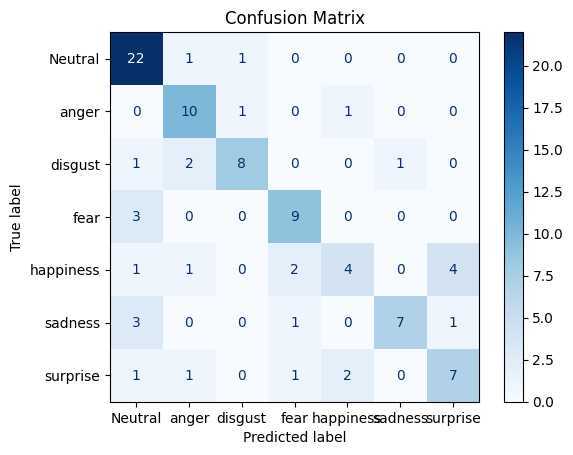


SVM Accuracy: 69.792%
              precision    recall  f1-score   support

     Neutral       0.71      0.92      0.80        24
       anger       0.67      0.83      0.74        12
     disgust       0.80      0.67      0.73        12
        fear       0.69      0.75      0.72        12
   happiness       0.57      0.33      0.42        12
     sadness       0.88      0.58      0.70        12
    surprise       0.58      0.58      0.58        12

    accuracy                           0.70        96
   macro avg       0.70      0.67      0.67        96
weighted avg       0.70      0.70      0.69        96



In [ ]:
svm_model = SVC(kernel='linear')
acc_svm = preprocess_split_train_test(sav,svm_model,'SVM',rs=6,apply_LDA=False)

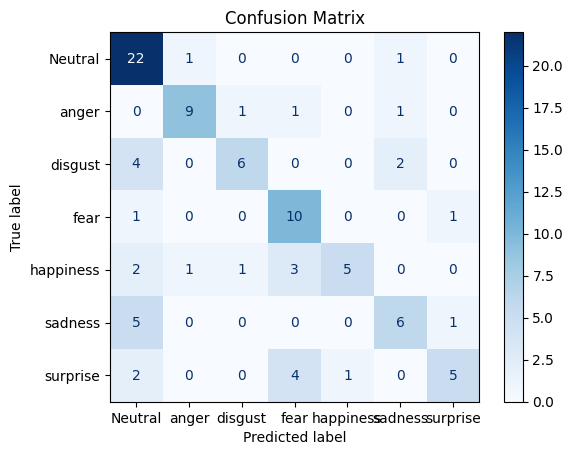


KNN Accuracy: 65.625%
              precision    recall  f1-score   support

     Neutral       0.61      0.92      0.73        24
       anger       0.82      0.75      0.78        12
     disgust       0.75      0.50      0.60        12
        fear       0.56      0.83      0.67        12
   happiness       0.83      0.42      0.56        12
     sadness       0.60      0.50      0.55        12
    surprise       0.71      0.42      0.53        12

    accuracy                           0.66        96
   macro avg       0.70      0.62      0.63        96
weighted avg       0.69      0.66      0.64        96



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=21)
acc_knn = preprocess_split_train_test(sav,knn_model,'KNN',rs=6)

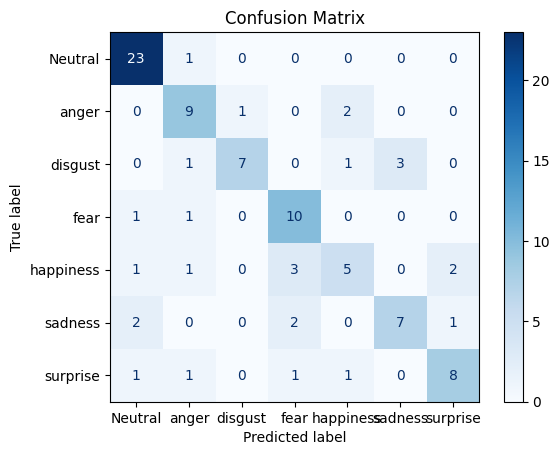


AdaBoost Accuracy: 71.875%
              precision    recall  f1-score   support

     Neutral       0.82      0.96      0.88        24
       anger       0.64      0.75      0.69        12
     disgust       0.88      0.58      0.70        12
        fear       0.62      0.83      0.71        12
   happiness       0.56      0.42      0.48        12
     sadness       0.70      0.58      0.64        12
    surprise       0.73      0.67      0.70        12

    accuracy                           0.72        96
   macro avg       0.71      0.68      0.69        96
weighted avg       0.72      0.72      0.71        96



In [ ]:
lr_model = LogisticRegression(C=0.3,max_iter=200)
ab_model = AdaBoostClassifier(estimator=lr_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(sav,ab_model,'AdaBoost',apply_smote=True,rs=6,apply_LDA=False)

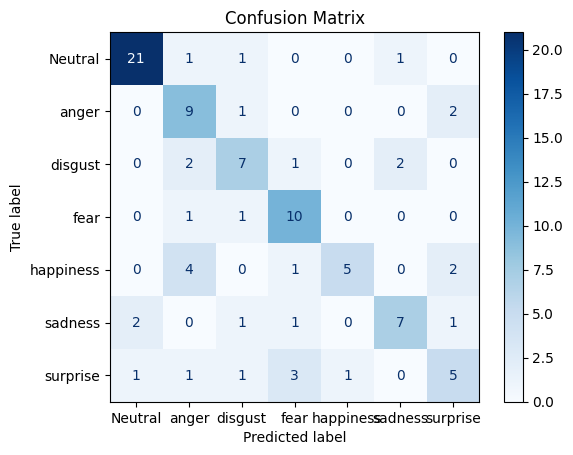


Naive Bayes Accuracy: 66.667%
              precision    recall  f1-score   support

     Neutral       0.88      0.88      0.88        24
       anger       0.50      0.75      0.60        12
     disgust       0.58      0.58      0.58        12
        fear       0.62      0.83      0.71        12
   happiness       0.83      0.42      0.56        12
     sadness       0.70      0.58      0.64        12
    surprise       0.50      0.42      0.45        12

    accuracy                           0.67        96
   macro avg       0.66      0.64      0.63        96
weighted avg       0.69      0.67      0.66        96



In [ ]:
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(sav,nb_model,'Naive Bayes',apply_smote=True,rs=6)

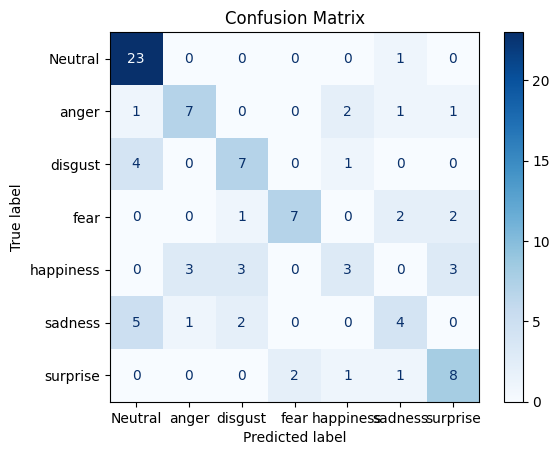


XGBoost Accuracy: 61.458%
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        24
           1       0.64      0.58      0.61        12
           2       0.54      0.58      0.56        12
           3       0.78      0.58      0.67        12
           4       0.43      0.25      0.32        12
           5       0.44      0.33      0.38        12
           6       0.57      0.67      0.62        12

    accuracy                           0.61        96
   macro avg       0.58      0.57      0.56        96
weighted avg       0.60      0.61      0.60        96



In [ ]:
xgb_model = XGBClassifier(random_state=42)
acc_xgb = preprocess_split_train_test(sav,xgb_model,'XGBoost',apply_LDA=False)

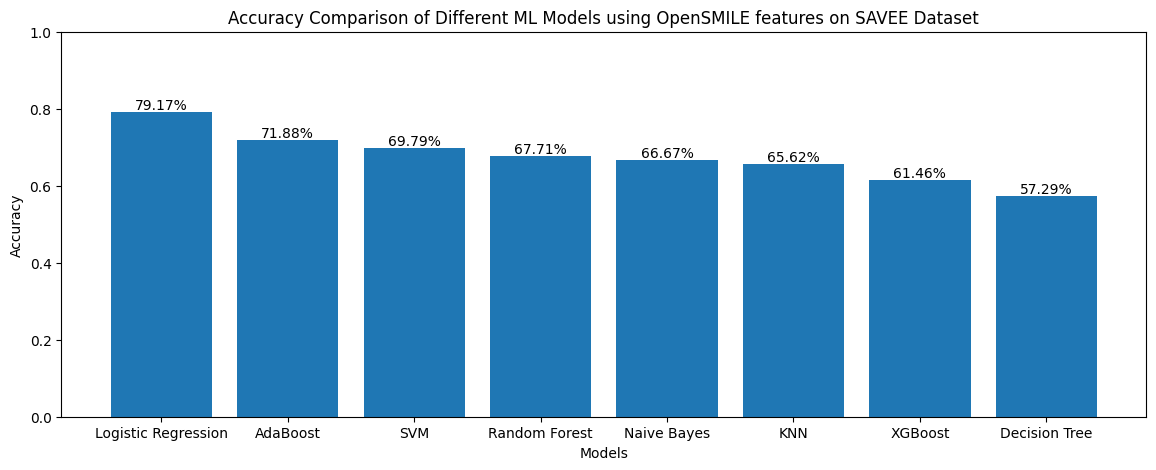

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN','AdaBoost','Naive Bayes','XGBoost']
accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn,acc_ab,acc_nb,acc_xgb]
modacc = dict(zip(models, accuracies))
modacc = sorted(modacc.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*modacc)
plt.figure(figsize=(14, 5))
bars = plt.bar(models, accuracies)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
plt.title(f'Accuracy Comparison of Different ML Models using OpenSMILE features on SAVEE Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Training and Testing on IEMOCAP Dataset

In [ ]:
iem = iem[iem['label'].isin(['angry', 'happy', 'sad', 'neutral','frustrated'])].reset_index(drop=True)
iem.shape

(7380, 6374)

In [ ]:
def train_test_model(trainX,testX,trainY,testY,le,model,name,apply_smote=False,printres=True,returnModelFiles=False):
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  model.fit(trainX, trainY)
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  return acc

In [ ]:
x = iem.drop(['label'], axis=1)
y = iem['label']
le = LabelEncoder()
y2 = le.fit_transform(y)
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=536,stratify=y)
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
lda = LinearDiscriminantAnalysis()
trainX2 = lda.fit_transform(trainX, trainY)
testX2 = lda.transform(testX)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


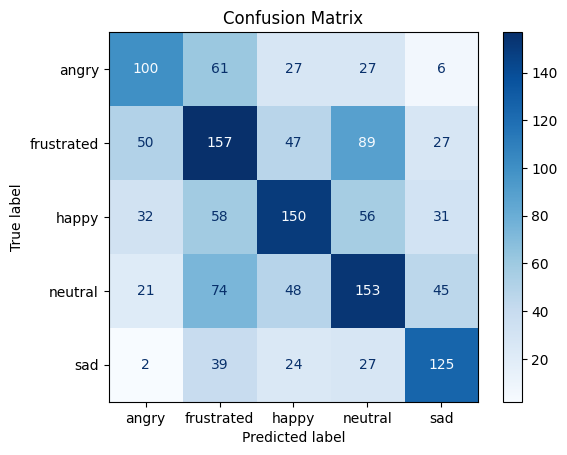


Logistic Regression Accuracy: 46.409%
              precision    recall  f1-score   support

       angry       0.49      0.45      0.47       221
  frustrated       0.40      0.42      0.41       370
       happy       0.51      0.46      0.48       327
     neutral       0.43      0.45      0.44       341
         sad       0.53      0.58      0.55       217

    accuracy                           0.46      1476
   macro avg       0.47      0.47      0.47      1476
weighted avg       0.47      0.46      0.46      1476



In [ ]:
lr_model = LogisticRegression(C=0.3,class_weight='balanced')
lr_model,scaler,acc_lr = train_test_model(trainX,testX,trainY,testY,le,lr_model,'Logistic Regression',returnModelFiles=True)

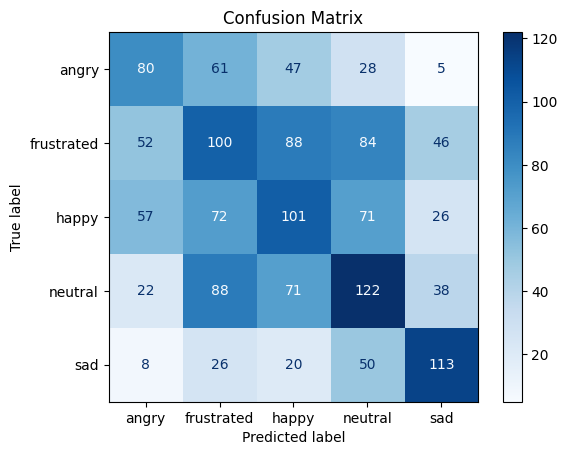


Decision Tree Accuracy: 34.959%
              precision    recall  f1-score   support

       angry       0.37      0.36      0.36       221
  frustrated       0.29      0.27      0.28       370
       happy       0.31      0.31      0.31       327
     neutral       0.34      0.36      0.35       341
         sad       0.50      0.52      0.51       217

    accuracy                           0.35      1476
   macro avg       0.36      0.36      0.36      1476
weighted avg       0.35      0.35      0.35      1476



In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=100)
acc_dt = train_test_model(trainX,testX,trainY,testY,le,dt_model,'Decision Tree',apply_smote=True)

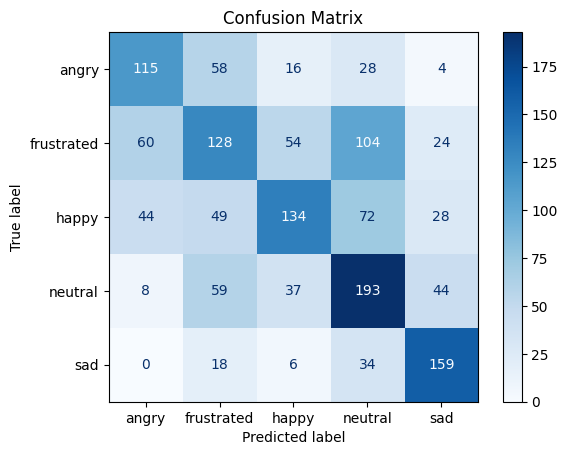


Random Forest Accuracy: 49.390%
              precision    recall  f1-score   support

       angry       0.51      0.52      0.51       221
  frustrated       0.41      0.35      0.38       370
       happy       0.54      0.41      0.47       327
     neutral       0.45      0.57      0.50       341
         sad       0.61      0.73      0.67       217

    accuracy                           0.49      1476
   macro avg       0.50      0.51      0.50      1476
weighted avg       0.49      0.49      0.49      1476



In [ ]:
rf_model = RandomForestClassifier(n_estimators=150,random_state=20)
acc_rf = train_test_model(trainX,testX,trainY,testY,le,rf_model,'Random Forest',apply_smote=True)

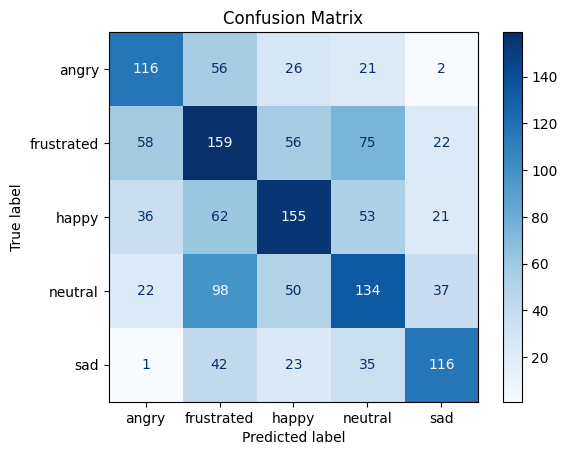


SVM Accuracy: 46.070%
              precision    recall  f1-score   support

       angry       0.50      0.52      0.51       221
  frustrated       0.38      0.43      0.40       370
       happy       0.50      0.47      0.49       327
     neutral       0.42      0.39      0.41       341
         sad       0.59      0.53      0.56       217

    accuracy                           0.46      1476
   macro avg       0.48      0.47      0.47      1476
weighted avg       0.46      0.46      0.46      1476



In [ ]:
svm_model = SVC(kernel='linear')
acc_svm = train_test_model(trainX,testX,trainY,testY,le,svm_model,'SVM')

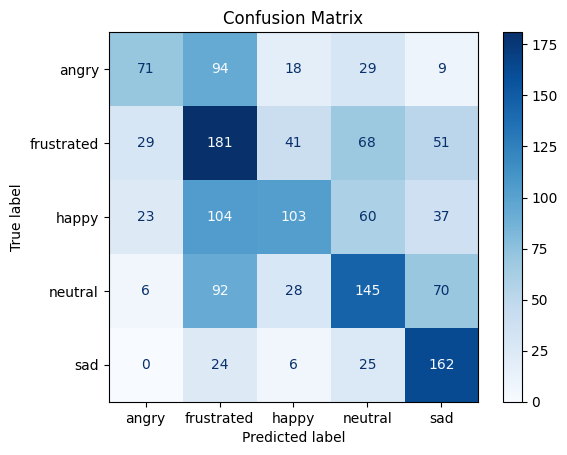


KNN Accuracy: 44.851%
              precision    recall  f1-score   support

       angry       0.55      0.32      0.41       221
  frustrated       0.37      0.49      0.42       370
       happy       0.53      0.31      0.39       327
     neutral       0.44      0.43      0.43       341
         sad       0.49      0.75      0.59       217

    accuracy                           0.45      1476
   macro avg       0.48      0.46      0.45      1476
weighted avg       0.47      0.45      0.44      1476



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=13)
acc_knn = train_test_model(trainX,testX,trainY,testY,le,knn_model,'KNN')

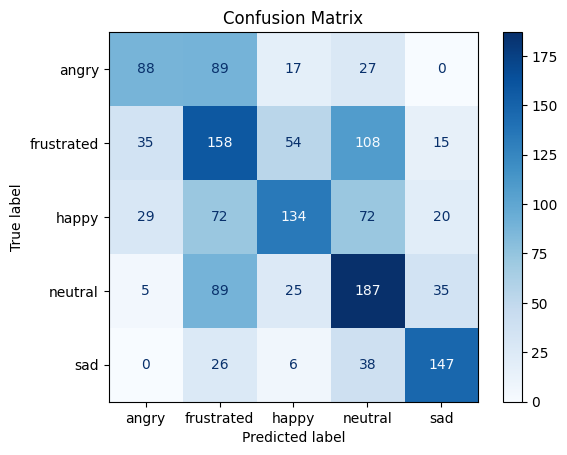


AdaBoost Accuracy: 48.374%
              precision    recall  f1-score   support

       angry       0.56      0.40      0.47       221
  frustrated       0.36      0.43      0.39       370
       happy       0.57      0.41      0.48       327
     neutral       0.43      0.55      0.48       341
         sad       0.68      0.68      0.68       217

    accuracy                           0.48      1476
   macro avg       0.52      0.49      0.50      1476
weighted avg       0.50      0.48      0.49      1476



In [ ]:
ab_model = AdaBoostClassifier(estimator=rf_model,algorithm='SAMME')
acc_ab = train_test_model(trainX,testX,trainY,testY,le,ab_model,'AdaBoost')

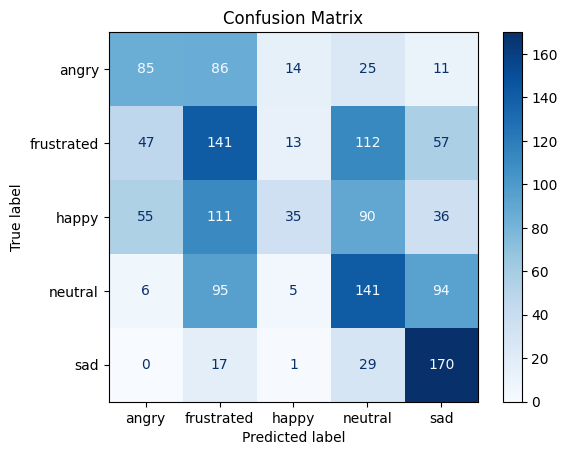


Naive Bayes Accuracy: 38.753%
              precision    recall  f1-score   support

       angry       0.44      0.38      0.41       221
  frustrated       0.31      0.38      0.34       370
       happy       0.51      0.11      0.18       327
     neutral       0.36      0.41      0.38       341
         sad       0.46      0.78      0.58       217

    accuracy                           0.39      1476
   macro avg       0.42      0.41      0.38      1476
weighted avg       0.41      0.39      0.36      1476



In [ ]:
nb_model = GaussianNB()
acc_nb = train_test_model(trainX,testX,trainY,testY,le,nb_model,'Naive Bayes',apply_smote=True)

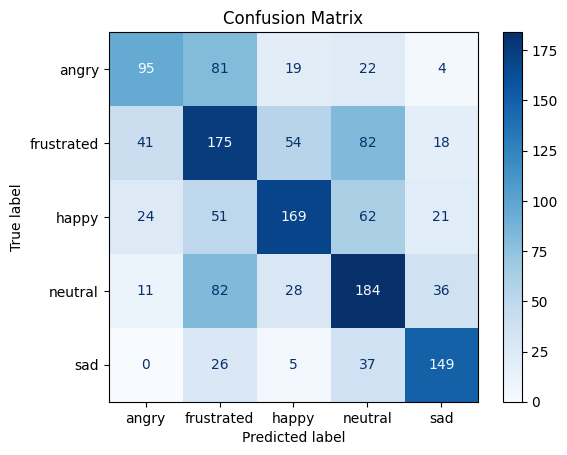


XGBoost Accuracy: 52.304%
              precision    recall  f1-score   support

           0       0.56      0.43      0.48       221
           1       0.42      0.47      0.45       370
           2       0.61      0.52      0.56       327
           3       0.48      0.54      0.51       341
           4       0.65      0.69      0.67       217

    accuracy                           0.52      1476
   macro avg       0.54      0.53      0.53      1476
weighted avg       0.53      0.52      0.52      1476



In [ ]:
xgb_model = XGBClassifier(random_state=42)
acc_xgb = train_test_model(trainX,testX,trainY,testY,le,xgb_model,'XGBoost')

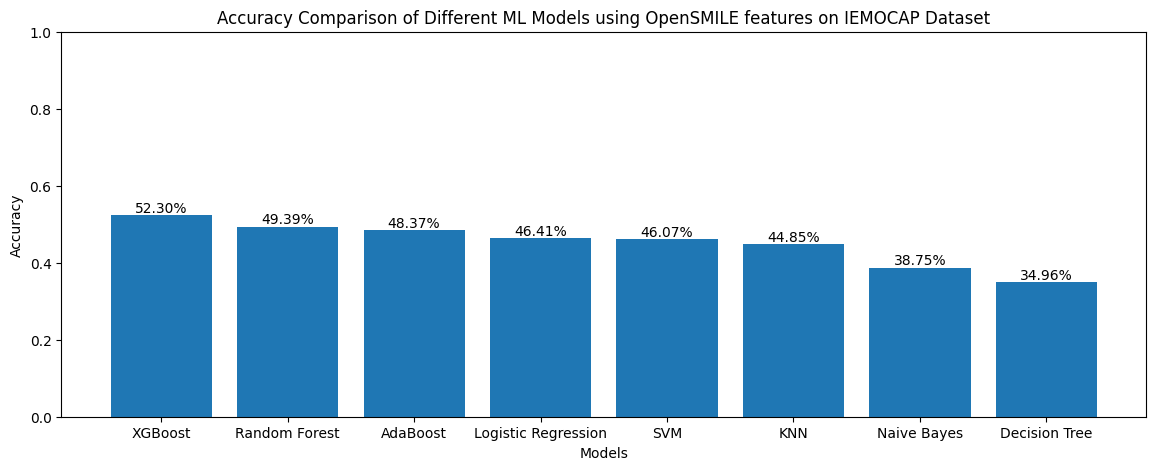

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN','AdaBoost','Naive Bayes','XGBoost']
accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn,acc_ab,acc_nb,acc_xgb]
modacc = dict(zip(models, accuracies))
modacc = sorted(modacc.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*modacc)
plt.figure(figsize=(14, 5))
bars = plt.bar(models, accuracies)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
plt.title(f'Accuracy Comparison of Different ML Models using OpenSMILE features on IEMOCAP Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()